### Naive forecasting on 2017

In [30]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from darts import TimeSeries
from darts.models import NaiveSeasonal, NaiveDrift
from darts.metrics import mape, mae, rmse

sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2010-01-01", end="2017-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# split into train (up to 2012-2016) and test (2017)
train_ts, test_ts = series.split_before(pd.Timestamp("2017-01-01"))

C:\Users\USER\AppData\Local\Temp\ipykernel_21216\4004957150.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


### Navie Seasonal

In [35]:
naive = NaiveSeasonal(K=52) # 52 weeks pattern to be repeated
naive.fit(train_ts)
naive_forecast = naive.predict(len(test_ts))

In [36]:
# shifting up forcast result
# extract the last training value and the first forecast value
last_train_value     = train_ts.values()[-1, 0]
first_forecast_value = naive_forecast.values()[0, 0]

# compute the additive offset
offset = last_train_value - first_forecast_value

# shift the entire forecast up (or down) by that offset
naive_forecast_shifted = naive_forecast + offset

### Linear regression

In [2]:
train_ser = train_ts.to_series()
test_ser  = test_ts.to_series()

x_train = (train_ser.index - train_ser.index[0]).days.values.reshape(-1, 1)
y_train = train_ser.values

model = LinearRegression()
model.fit(x_train, y_train)

x_test = (test_ser.index - train_ser.index[0]).days.values.reshape(-1, 1)

# predict the future trend
y_pred = model.predict(x_test)
lin_forecast = TimeSeries.from_times_and_values(test_ser.index, y_pred) # convert to darts TimeSeries

In [3]:
# "lin_forecast" or "naive_forecast_shifted" for forecast plotting
# get only the part of train_ts from 2014-01-01 onward
train_slice = train_ts.slice(pd.Timestamp("2014-01-01"), train_ts.end_time())
train_slice_ser = train_slice.to_series()

t0 = train_ser.index[0]  # same origin you used before
x_train_slice = ((train_slice_ser.index - t0).days).values.reshape(-1, 1)

# predict the past trend
y_train_pred = model.predict(x_train_slice)
past_trend = TimeSeries.from_times_and_values(train_slice_ser.index, y_train_pred) # convert to darts TimeSeries

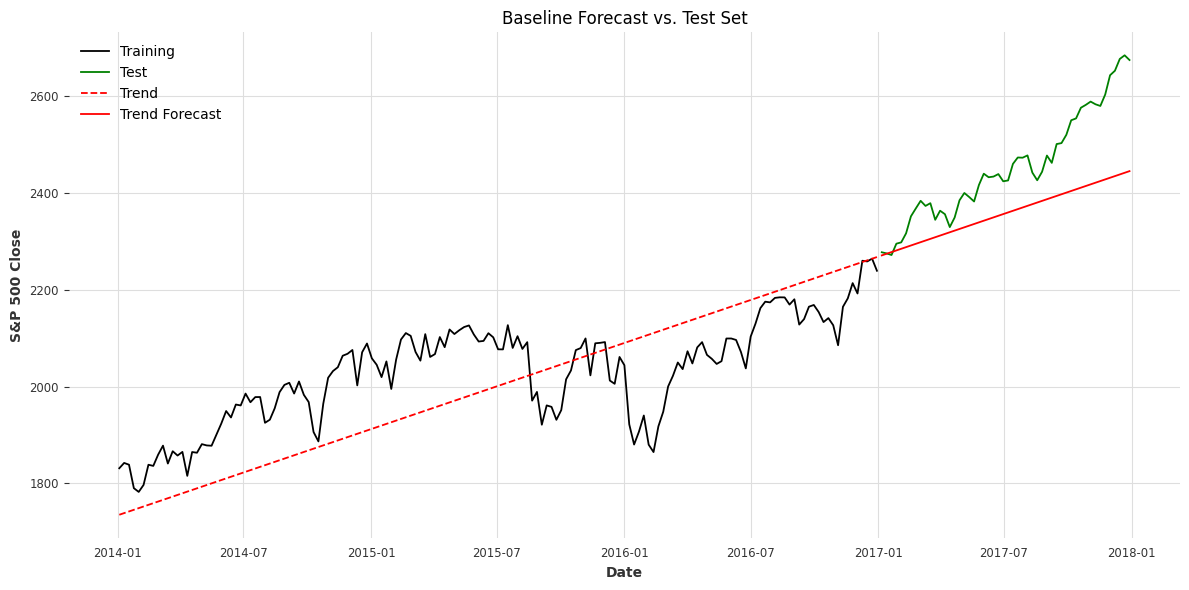

MAPE: 3.74%
MAE:  94.19
RMSE: 113.07



In [4]:
# plot train, test, and forecast
plt.figure(figsize=(12, 6))

# plot actual data
plt.plot(train_slice.time_index, train_slice.values(), label="Training")
plt.plot(test_ts.time_index, test_ts.values(), label="Test", color="green")

# plot trend
plt.plot(past_trend.time_index, past_trend.values(), label="Trend", color="red", linestyle="dashed")
plt.plot(lin_forecast.time_index, lin_forecast.values(), label="Trend Forecast", color="red")

# labels
plt.title("Baseline Forecast vs. Test Set")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.tight_layout()
plt.show()

# evaluate
print(f"MAPE: {mape(test_ts, lin_forecast):.2f}%")
print(f"MAE:  {mae(test_ts, lin_forecast):.2f}")
print(f"RMSE: {rmse(test_ts, lin_forecast):.2f}\n")

### Saving prediction

In [17]:
import os
import pandas as pd

def save_preds(ts_actual, ts_pred, model_name, type, path="results"):
    # turn into pandas.Series and pick only the timestamps present in both
    actual = ts_actual.to_series()
    pred   = ts_pred.to_series()
    common = actual.index.intersection(pred.index)

    # build a simple DataFrame
    df = pd.DataFrame({
        "actual":     actual.loc[common],
        "prediction": pred.loc[common],
        "model":      model_name
    })
    df.index.name = "timestamp"

    # ensure the output folder exists and save
    os.makedirs(path, exist_ok=True)
    out_fn = os.path.join(path, f"{model_name}_{type}.csv")
    df.to_csv(out_fn, index=True)

    return df

In [18]:
df_2017 = save_preds(test_ts, lin_forecast, model_name="Baseline", type="test_2017", path="results")

### Navie forecasting on 2023

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import NaiveSeasonal
from darts.metrics import mape, mae, rmse

sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2014-01-01", end="2024-01-01")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# split into train and test
train_ts, test_ts = series.split_before(pd.Timestamp("2023-01-01"))

C:\Users\USER\AppData\Local\Temp\ipykernel_21216\2846105459.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


### Navie Seasonal

In [76]:
naive = NaiveSeasonal(K=52) # 52 weeks pattern to be repeated
naive.fit(train_ts)
naive_forecast = naive.predict(len(test_ts))

In [77]:
# shifting up forcast result
# extract the last training value and the first forecast value
last_train_value     = train_ts.values()[-1, 0]
first_forecast_value = naive_forecast.values()[0, 0]

# compute the additive offset
offset = last_train_value - first_forecast_value

# shift the entire forecast up (or down) by that offset
naive_forecast_shifted = naive_forecast + offset

### Linear regression

In [24]:
train_ser = train_ts.to_series()
test_ser  = test_ts.to_series()

x_train = (train_ser.index - train_ser.index[0]).days.values.reshape(-1, 1)
y_train = train_ser.values

model = LinearRegression()
model.fit(x_train, y_train)

x_test = (test_ser.index - train_ser.index[0]).days.values.reshape(-1, 1)
y_pred = model.predict(x_test)

lin_forecast_2 = TimeSeries.from_times_and_values(test_ser.index, y_pred)

In [25]:
# "lin_forecast" or "naive_forecast_shifted" for forecast plotting
# get only the part of train_ts from 2019-01-01 onward
train_slice = train_ts.slice(pd.Timestamp("2019-01-01"), train_ts.end_time())
train_slice_ser = train_slice.to_series()

t0 = train_ser.index[0]  # same origin you used before
x_train_slice = ((train_slice_ser.index - t0).days).values.reshape(-1, 1)

# predict the past trend
y_train_pred = model.predict(x_train_slice)
past_trend = TimeSeries.from_times_and_values(train_slice_ser.index, y_train_pred) # convert to darts TimeSeries

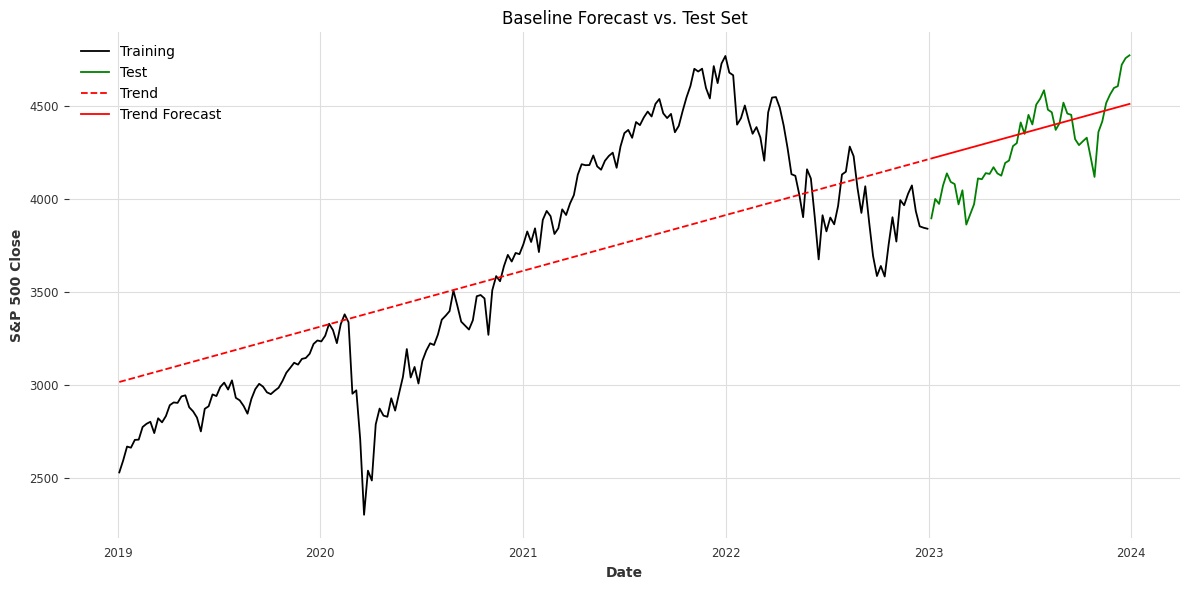

MAPE: 3.60%
MAE:  151.45
RMSE: 178.35



In [26]:
# plot train, test, and forecast
plt.figure(figsize=(12, 6))

# plot actual data
plt.plot(train_slice.time_index, train_slice.values(), label="Training")
plt.plot(test_ts.time_index, test_ts.values(), label="Test", color="green")

# plot trend
plt.plot(past_trend.time_index, past_trend.values(), label="Trend", color="red", linestyle="dashed")
plt.plot(lin_forecast_2.time_index, lin_forecast_2.values(), label="Trend Forecast", color="red")

# labels
plt.title("Baseline Forecast vs. Test Set")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.tight_layout()
plt.show()

# evaluate
print(f"MAPE: {mape(test_ts, lin_forecast_2):.2f}%")
print(f"MAE:  {mae(test_ts, lin_forecast_2):.2f}")
print(f"RMSE: {rmse(test_ts, lin_forecast_2):.2f}\n")

In [27]:
df_2023 = save_preds(test_ts, lin_forecast_2, model_name="Baseline", type="test_2023", path="results")

### Navie backtest on year 2023 and 2024

In [40]:
sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2012-01-01", end="2024-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

# resample to weekly
weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# back test period
backtest_start = pd.Timestamp("2023-01-01")
backtest_end   = pd.Timestamp("2024-12-31")

C:\Users\USER\AppData\Local\Temp\ipykernel_21216\1568744433.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [41]:
#naive = NaiveSeasonal(K=1) # K=1 -> seasonal naive degenerates to pure last‐value naive
naive = NaiveDrift() # same results as navieseasonal k = 1
naive.fit(series[:backtest_start])

NaiveDrift()

In [42]:
# Rolling 1‐week‐ahead backtest
backtest_naive = naive.historical_forecasts(
    series=series,
    start=backtest_start,
    forecast_horizon=1,
    stride=1,
    last_points_only=True
)

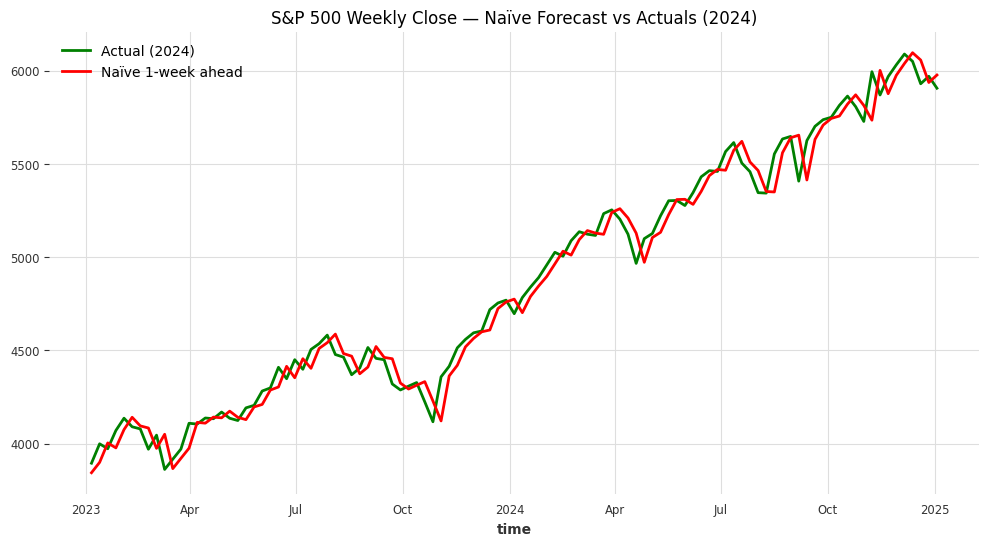

MAPE: 1.41%
MAE:  68.40
RMSE: 86.83


In [43]:
actuals_bt = series[backtest_start:backtest_end]

plt.figure(figsize=(12,6))
actuals_bt.plot(label="Actual (2024)", color="green")
backtest_naive.plot(label="Naïve 1‑week ahead", color="red")
plt.legend()
plt.title("S&P 500 Weekly Close — Naïve Forecast vs Actuals (2024)")
plt.show()

# Metrics
print(f"MAPE: {mape(actuals_bt, backtest_naive):.2f}%")
print(f"MAE:  {mae(actuals_bt, backtest_naive):.2f}")
print(f"RMSE: {rmse(actuals_bt, backtest_naive):.2f}")

In [45]:
from sklearn.metrics import precision_score

# This is considered a classification problem from a regression underlying structure
# convert both to pandas Series for easy shifting/alignment
pred = backtest_naive.to_series()     # your one-week-ahead forecasts
actual = actuals_bt.to_series()       # the real weekly closes

# get last week’s actual price at each forecast date
prev_price = actual.shift(1)

# drop the very first point where prev_price is NaN
mask = prev_price.notna()
pred = pred[mask]
actual = actual[mask]
prev_price = prev_price[mask]

# compute predicted & actual directions: +1 for up, -1 for down
pred_dir   = np.where(pred   > prev_price,  1, -1)
actual_dir = np.where(actual > prev_price,  1, -1)

# compute directional accuracy
dir_acc = (pred_dir == actual_dir).mean() * 100
print(f"Directional accuracy: {dir_acc:.2f}%")

# compute precision for the "up" class
y_pred = (pred_dir == 1)
y_true = (actual_dir == 1)
precision = precision_score(y_true, y_pred) * 100
print(f"Precision (stock actually increase): {precision:.2f}%") # when model says goes up, stock actually goes up, the correct prediction rate

Directional accuracy: 61.54%
Precision (stock actually increase): 61.54%


The accuracy simply reflects that about how many percent rate of weeks in the test set were 'down' weeks, i.e. the model is 'right' exactly when the market fell.

Because we never predict an up‐move (never produce a +1), there are no positive predictions to compute precision on—so precision_score returns 0.00% (and typically emits a warning about no positive predictions).

In [39]:
df_backtest= save_preds(actuals_bt, backtest_naive, model_name="Baseline", type="backtest", path="results")